Run streamflow PCA on USGS gages from WY1983 - 2011. This short period means it can be used with ERA-I and OISST fields. Note also that we're generally seeing the same PC1 and PC2 patterns as in 1925 and 1975.

In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('..')

import sqlite3
import numpy as np
import pandas as pd
import eofs.standard as eofs
import pylab as plt
import scipy.stats as stats
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
import seaborn as sns
import xarray as xr
import tools

In [3]:
sns.set_style('whitegrid')
mpl.rcParams['axes.unicode_minus'] = False  # Otherwise the "-" don't render on PDF figures
mpl.rcParams.update({'font.size': 6})  # GRL figure font-size.
mpl.rcParams.update({'axes.titlesize': 'medium',
                     'axes.labelsize': 'medium',
                     'legend.fontsize': 'medium',
                     'xtick.labelsize': 'medium',
                     'ytick.labelsize': 'medium'})  # GRL figure font-size.

In [4]:
DB_PATH = '../data/stationdb.sqlite'
HGT_PATH = '../data/tcrv2_z500_season.nc'
SST_PATH = '../data/ersstv3b_season.nc'
WESTOFLON = -104
EASTOFLON = -125
WATER_YEAR = {'low': 1983,
              'high': 2011}
WY_RANGE = np.arange(WATER_YEAR['low'], WATER_YEAR['high'] + 1)
CAL_YEAR = {'low': WATER_YEAR['low'] - 1,
            'high': WATER_YEAR['high']}

In [5]:
# Grab data from SQLITE3 DB.
target_stations = tools.check_wy(DB_PATH, WATER_YEAR['low'], WATER_YEAR['high'],
                                 WESTOFLON, EASTOFLON)
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT site_no, year_nu, mean_va FROM StationWY 
               WHERE year_nu <= {wy_high} AND year_nu >= {wy_low} AND site_no IN ({seq}) 
               GROUP BY site_no, year_nu 
               ORDER BY site_no, year_nu ASC""".format(wy_low = str(WATER_YEAR['low']), 
                                                       wy_high = str(WATER_YEAR['high']), 
                                                       seq = ','.join(["?"] * len(target_stations)))
raw = pd.read_sql(sql_query, conn, 
                  params = target_stations, 
                  index_col = ['year_nu', 'site_no'])
conn.close()

In [6]:
# Get corresponding latitude and longitude.
conn = sqlite3.connect(DB_PATH)
sql_query = """SELECT "STATION ID", LAT_GAGE, LONG_GAGE FROM StationInfo 
               WHERE "STATION ID" IN ({seq}) 
               ORDER BY "STATION ID" ASC""".format(seq = ','.join(['?'] * len(target_stations)))
latlon = pd.read_sql(sql_query, conn, params = target_stations)
conn.close()

## Streamflow gage map

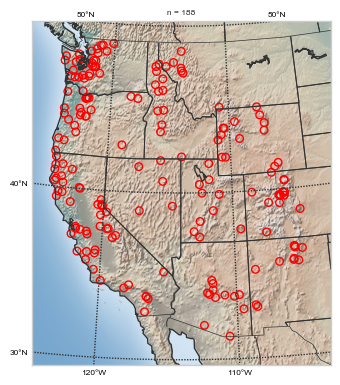

In [7]:
out = tools.plot_gagesmap(latlon['LAT_GAGE'].as_matrix(), latlon['LONG_GAGE'].as_matrix())

## Standardize streamflow

In [8]:
parsed = raw.groupby(level = 'site_no')['mean_va'].transform(tools.spigamma)
# parsed = raw.groupby(level = "stationid")["meanCFS"].transform(tools.zscore)

## Basic North Test scree plot

In [9]:
examine_modes = 10
solver = eofs.Eof(parsed.unstack().as_matrix(), center = False)
eof = solver.eofsAsCovariance(neofs = examine_modes)
pc = solver.pcs(npcs = examine_modes, pcscaling = 1)
frac_var = solver.varianceFraction(examine_modes)

In [10]:
pc = pd.DataFrame(pc,
                  columns = ['PC' + str(i + 1) for i in range(examine_modes)],
                  index = pd.Index(WY_RANGE, name = 'wy'))

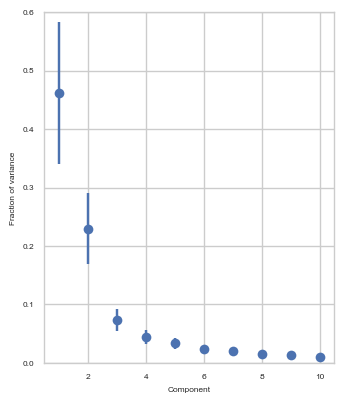

In [11]:
out = tools.plot_northtest(solver, nmodes = examine_modes)

In [12]:
retain_modes = 2

## PC time series from leading components

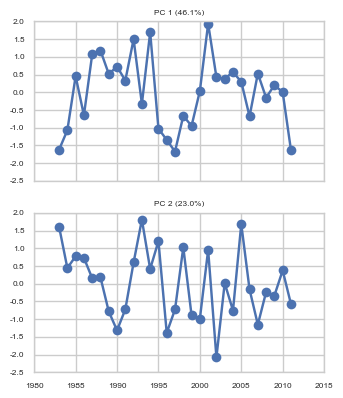

In [13]:
out = tools.plot_pc(solver, yr = WY_RANGE, nmodes = retain_modes)

## Leading EOFs mapped as covariance

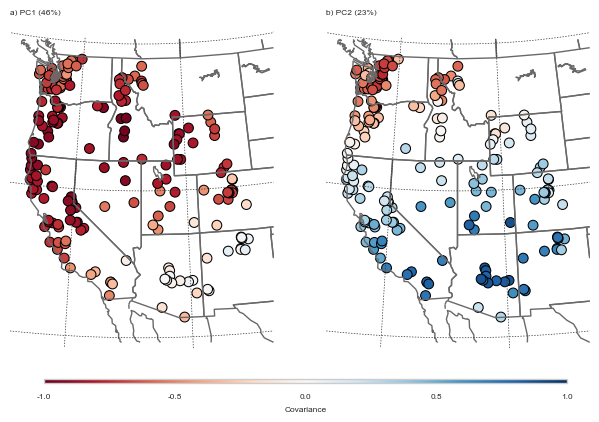

In [14]:
out = tools.plot_eof(solver, 
                     lat = latlon['LAT_GAGE'].as_matrix(),
                     lon = latlon['LONG_GAGE'].as_matrix(), 
                     nmodes = retain_modes)

# Point correlation & composite maps

In [15]:
with xr.open_dataset(HGT_PATH) as hgt:
    hgt_anom = hgt.z500[np.in1d(hgt['wy'], WY_RANGE)].copy()

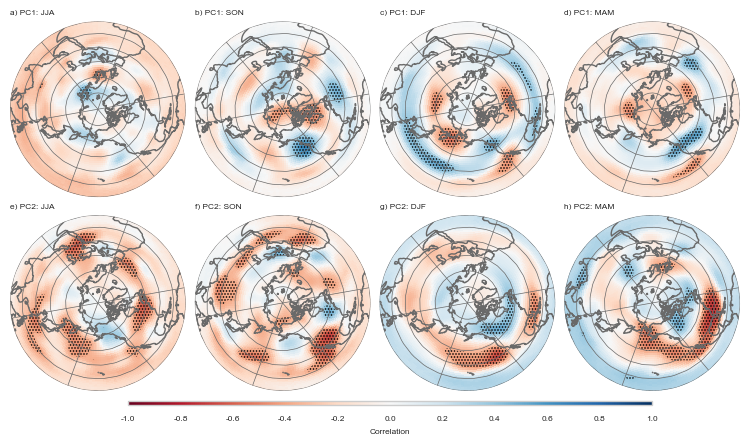

In [16]:
hgt_corrs = tools.pointfield_corr(field = hgt_anom, pc_df = pc)
out = tools.plot_pointfield_corr(hgt_corrs, map_type = 'north_hemisphere')

<xarray.DataArray 'Composite difference (m)' ()>
array(-78.18888888888978)
<xarray.DataArray 'Composite difference (m)' ()>
array(77.56507936507842)


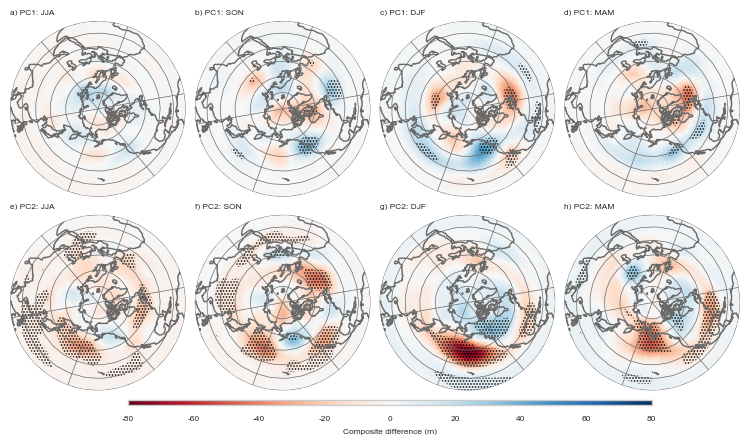

In [17]:
stat_str = 'Composite difference (m)'
hgt_ttest = tools.pointfield_ttest(stat_name = stat_str,
                                   field = hgt_anom, 
                                   pc_df = pc)

out = tools.plot_pointfield_ttest(hgt_ttest, 
                                  map_type = 'north_hemisphere', 
                                  stat_name = stat_str,
                                  vmin = -80, vmax = 80)

print(hgt_ttest[stat_str].min())
print(hgt_ttest[stat_str].max())

In [18]:
with xr.open_dataset(SST_PATH) as ersst:
    sst_anom = ersst.sst[np.in1d(ersst['wy'], WY_RANGE)].copy()

There might be a RuntimeWarning below. This is from NaNs over the poles in SST fields.

/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/stats.py:5084: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


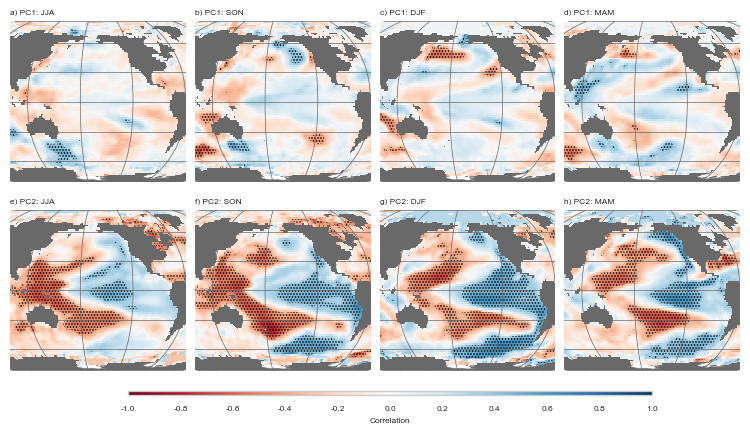

In [19]:
sst_corrs = tools.pointfield_corr(field = sst_anom, pc_df = pc)
out = tools.plot_pointfield_corr(sst_corrs, map_type = 'global')

/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/sbm/miniconda3/envs/riverpca/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/sbm/miniconda3/envs/riverp

<xarray.DataArray 'Composite difference (°C)' ()>
array(-1.3775482180952245)
<xarray.DataArray 'Composite difference (°C)' ()>
array(1.723311508707818)


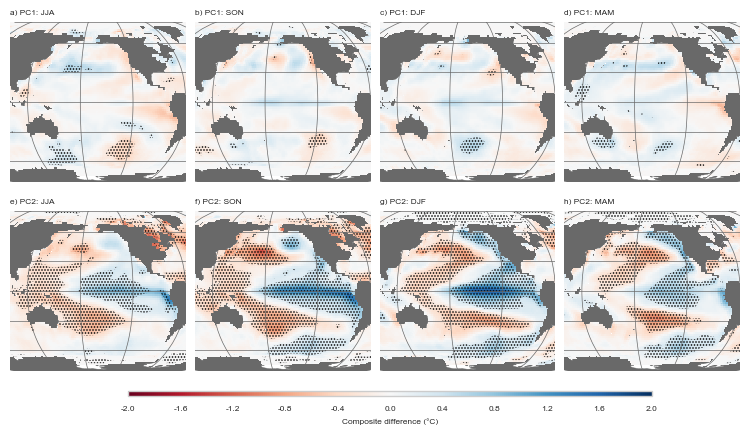

In [20]:
stat_str = 'Composite difference (°C)'
sst_ttest = tools.pointfield_ttest(stat_name = stat_str,
                                   field = sst_anom, 
                                   pc_df = pc)

out = tools.plot_pointfield_ttest(sst_ttest, 
                                  map_type = 'global', 
                                  stat_name = stat_str,
                                  vmin = -2, vmax = 2)

print(sst_ttest[stat_str].min())
print(sst_ttest[stat_str].max())